In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
import time

import sys
sys.path.append('../../')

from data.processing import get_data

import models

from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new, predict_r0_multipliers, save_r0_mul
from main.seir.sensitivity import calculate_sensitivity_and_plot
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
#from utils.generic.logging import log_wandb
from viz import plot_forecast, plot_top_k_trials, plot_ptiles, plot_r0_multipliers

import yaml

In [3]:
predictions_dict = {}

In [4]:
config_filename = 'dhanbad.yaml'
config = read_config(config_filename)

In [5]:
output_folder = '../../misc/reports/{}'.format(datetime.datetime.now().strftime("%Y_%m%d_%H%M%S"))

## Perform M1 and M2 fits

Performing m1 fit ..
loading from ../../misc/cache/dataframes_ts_29102020_tracker.pkl
splitting data ..
splitting data ..
          date      state   total  active  recovered  deceased     tested  \
0   2020-04-26  Jharkhand      82      66         13         3     7806.0   
1   2020-04-27  Jharkhand     103      83         17         3     8757.0   
2   2020-04-28  Jharkhand     105      83         19         3     9408.0   
3   2020-04-29  Jharkhand     107      85         19         3    10268.0   
4   2020-04-30  Jharkhand     110      88         19         3    10987.0   
..         ...        ...     ...     ...        ...       ...        ...   
182 2020-10-25  Jharkhand   99686    5844      92976       866  3109483.0   
183 2020-10-26  Jharkhand   99906    5666      93368       872  3126794.0   
184 2020-10-27  Jharkhand  100224    5474      93874       876  3152647.0   
185 2020-10-28  Jharkhand  100569    5363      94326       880  3193717.0   
186 2020-10-29  Jharkhand  1005

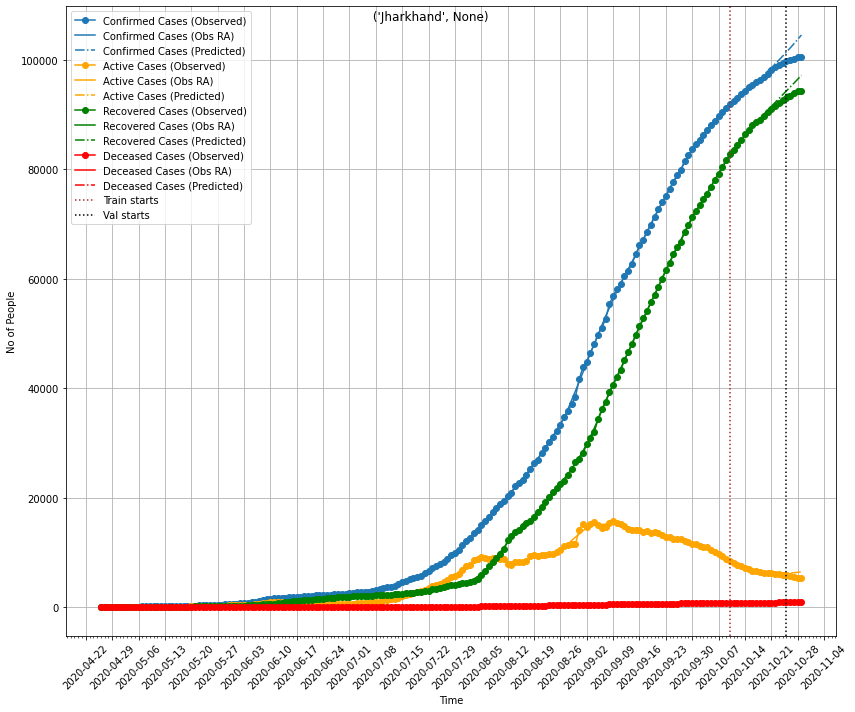

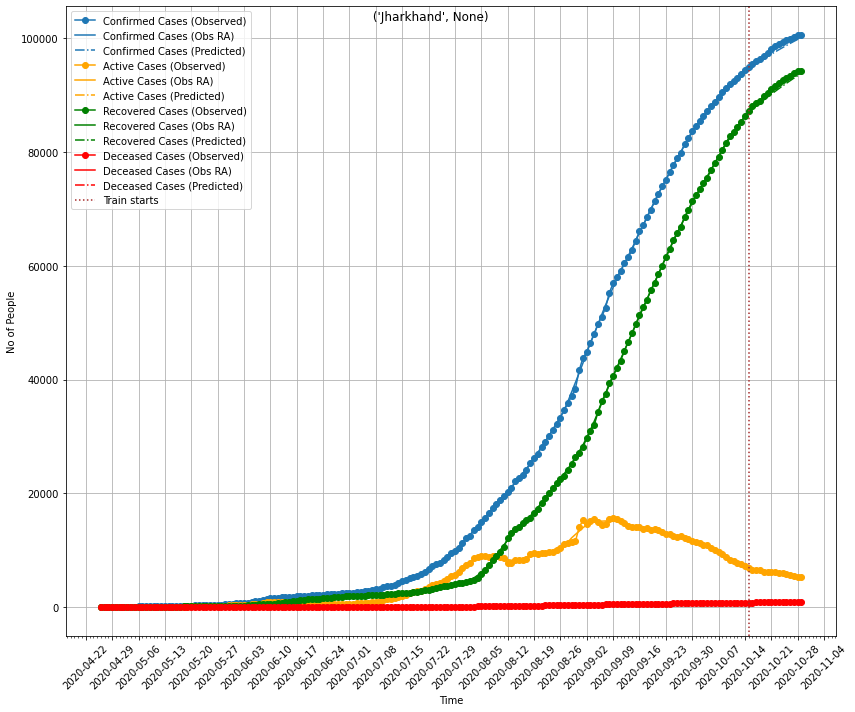

In [6]:
predictions_dict['m1'] = single_fitting_cycle(**copy.deepcopy(config['fitting'])) 

m2_params = copy.deepcopy(config['fitting'])
m2_params['split']['val_period'] = 0
predictions_dict['m2'] = single_fitting_cycle(**m2_params)

predictions_dict['fitting_date'] = datetime.datetime.now().strftime("%Y-%m-%d")

In [7]:
predictions_dict['m1']['best_params']

{'E_hosp_ratio': 0.20420785908379913,
 'I_hosp_ratio': 0.27940157674346117,
 'P_fatal': 0.020787742064838962,
 'T_inc': 4.503336006657463,
 'T_inf': 3.47288599579577,
 'T_recov': 8.404652399120133,
 'T_recov_fatal': 37.97060613713878,
 'lockdown_R0': 1.224084730868005}

In [8]:
predictions_dict['m2']['best_params']

{'E_hosp_ratio': 0.29652747151482384,
 'I_hosp_ratio': 0.18947028534530946,
 'P_fatal': 0.016734268025026994,
 'T_inc': 4.272687735578889,
 'T_inf': 3.6888077080655157,
 'T_recov': 12.212790074168918,
 'T_recov_fatal': 18.31935491956655,
 'lockdown_R0': 0.8504610992471393}

## Loss Dataframes

### M1 Loss DataFrame

In [9]:
predictions_dict['m1']['df_loss']

train      val
total      0.342169  2.73047
active      1.63815  14.1711
recovered  0.370146  2.07191
deceased   0.673951  1.96238

### M2 Loss DataFrame

In [10]:
predictions_dict['m2']['df_loss']

train
total      0.666953
active      1.47843
recovered  0.776749
deceased    1.03371

## Sensitivity Plot

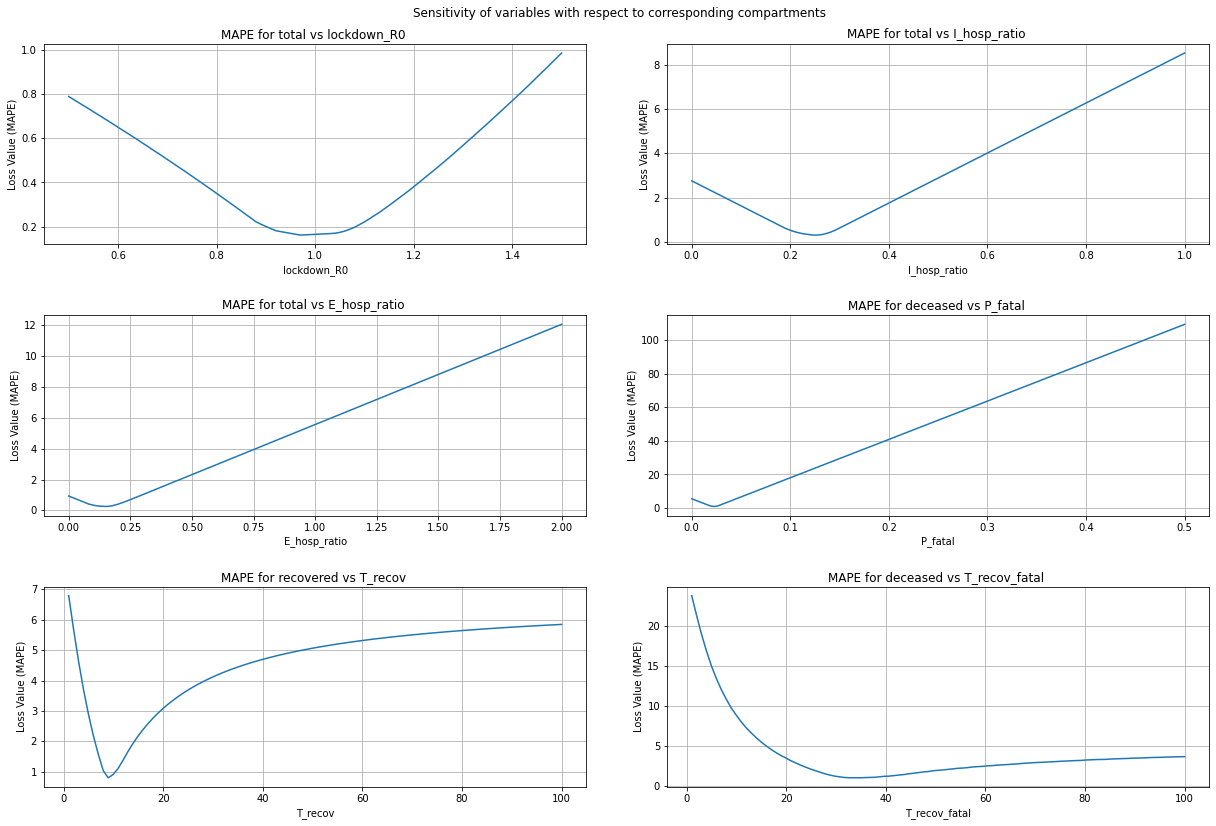

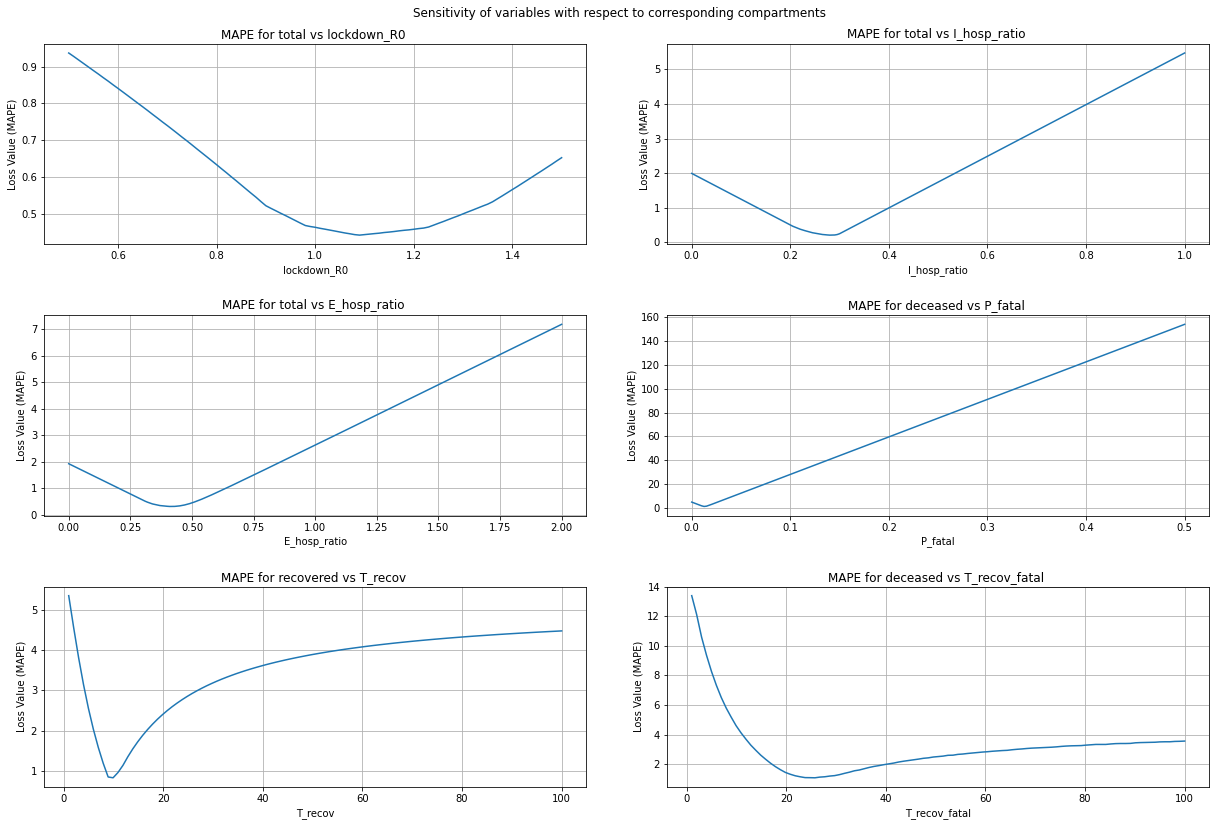

In [11]:
predictions_dict['m1']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m1')
predictions_dict['m2']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m2')

## Plot Forecasts

In [12]:
# M2 based forecasting for the next train_period + test_period + forecast_period (no validation period)
predictions_dict['m2']['forecasts'] = {}
predictions_dict['m2']['forecasts']['best'] = get_forecast(predictions_dict, train_fit='m2', 
                                                           model=config['fitting']['model'], 
                                                           days=config['forecast']['forecast_days'])

getting forecasts ..


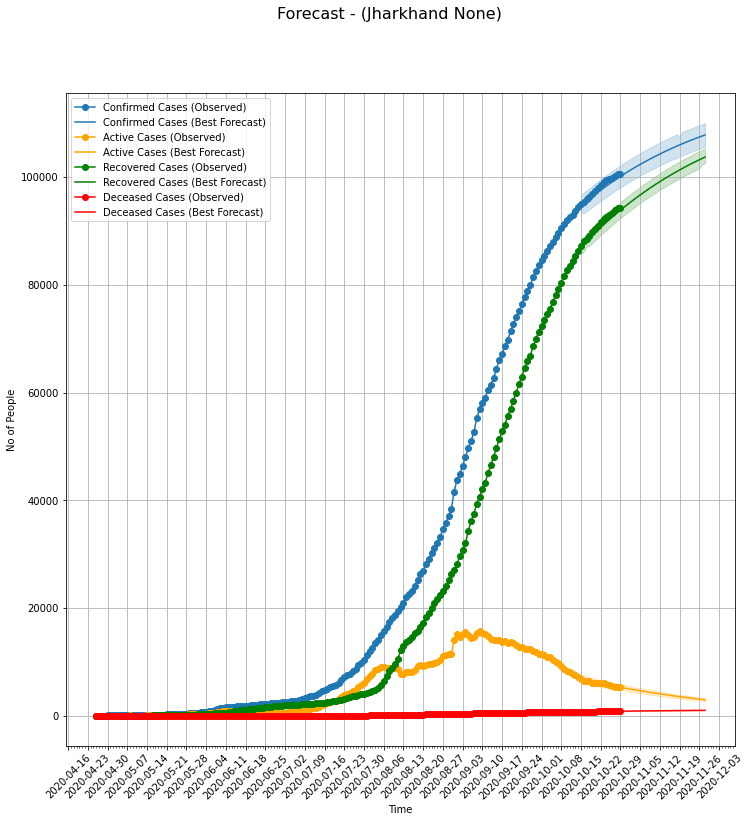

In [13]:
# Predictions plotted are for the most recent train_period days + test_period + forecast_period (no validation_period)
predictions_dict['m2']['plots']['forecast_best'] = plot_forecast(predictions_dict, 
                                                                 (config['fitting']['data']['dataloading_params']['state'], 
                                                                  config['fitting']['data']['dataloading_params']['district']), 
                                                                 error_bars=True)

In [14]:
predictions_dict['m1']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m1', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

14it [00:00, 133.97it/s]getting forecasts ..
1000it [00:08, 120.00it/s]


In [15]:
predictions_dict['m2']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m2', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

15it [00:00, 141.21it/s]getting forecasts ..
1000it [00:08, 119.99it/s]


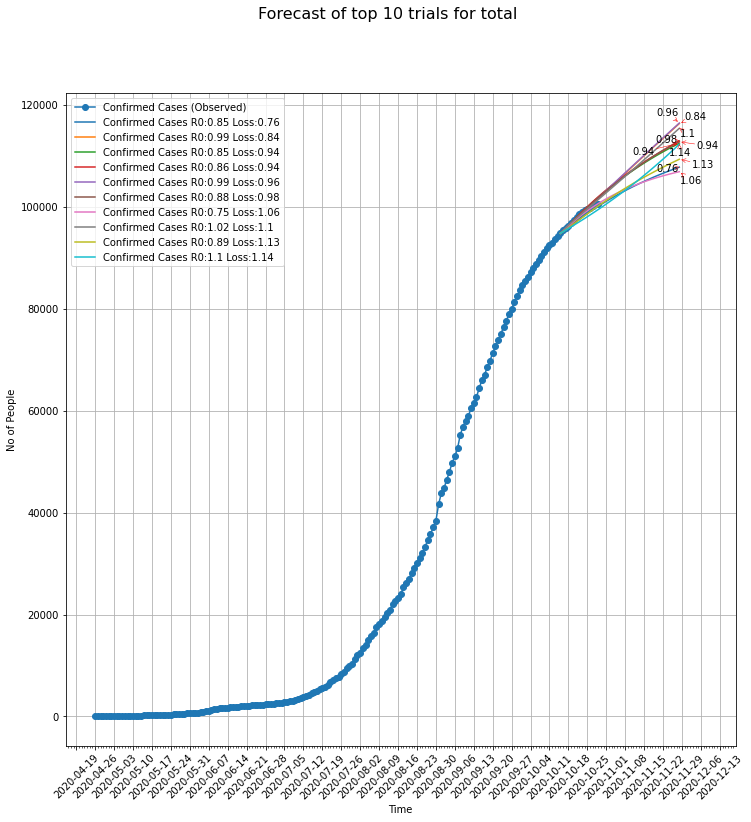

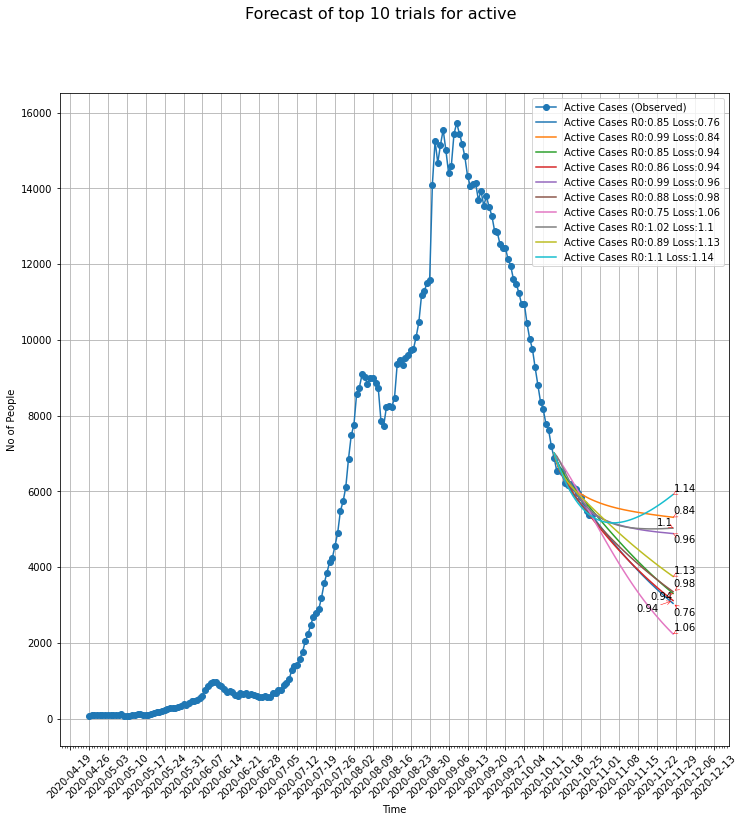

In [16]:
kforecasts = plot_top_k_trials(predictions_dict, train_fit='m2',
                               k=config['forecast']['num_trials_to_plot'],
                               which_compartments=config['forecast']['plot_topk_trials_for_columns'])

In [17]:
predictions_dict['m2']['plots']['forecasts_topk'] = {}
for column in config['forecast']['plot_topk_trials_for_columns']:
    predictions_dict['m2']['plots']['forecasts_topk'][column.name] = kforecasts[column]

## Uncertainty + Uncertainty Forecasts

In [18]:
uncertainty_args = {'predictions_dict': predictions_dict, **config['uncertainty']['uncertainty_params']}
uncertainty = config['uncertainty']['method'](**uncertainty_args)

100%|██████████| 100/100 [00:47<00:00,  2.09trial/s, best loss: 4.600981118092886]


In [19]:
uncertainty.beta_loss

{'active': 13.039782068255107,
 'recovered': 1.407404323357035,
 'deceased': 1.911500174366229,
 'total': 2.0452379063931723}

In [20]:
uncertainty_forecasts = uncertainty.get_forecasts()
for key in uncertainty_forecasts.keys():
    predictions_dict['m2']['forecasts'][key] = uncertainty_forecasts[key]['df_prediction']
    
predictions_dict['m2']['forecasts']['ensemble_mean'] = uncertainty.ensemble_mean_forecast

In [21]:
predictions_dict['m2']['beta'] = uncertainty.beta
predictions_dict['m2']['beta_loss'] = uncertainty.beta_loss
predictions_dict['m2']['deciles'] = uncertainty_forecasts

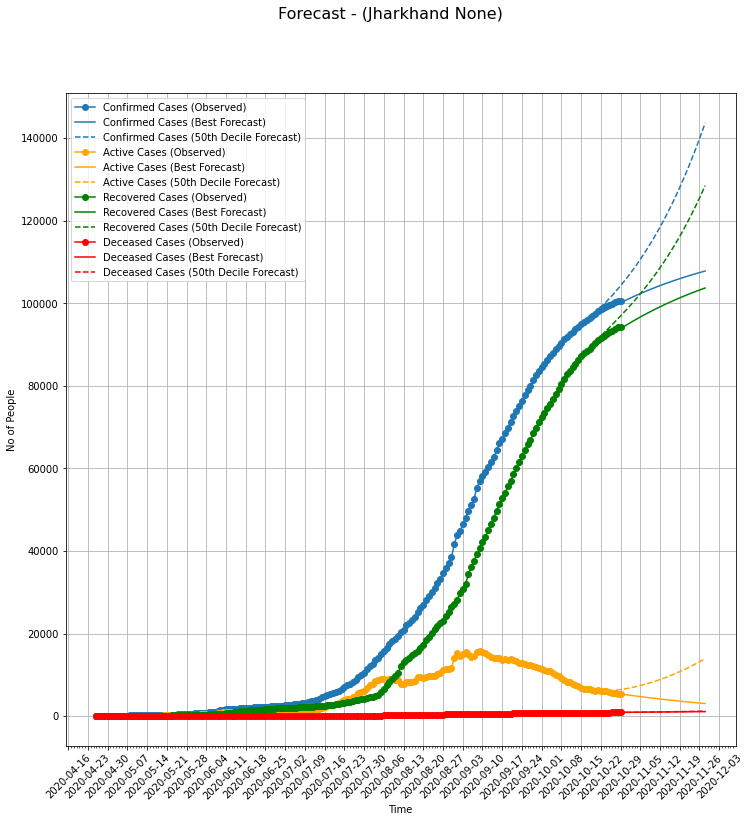

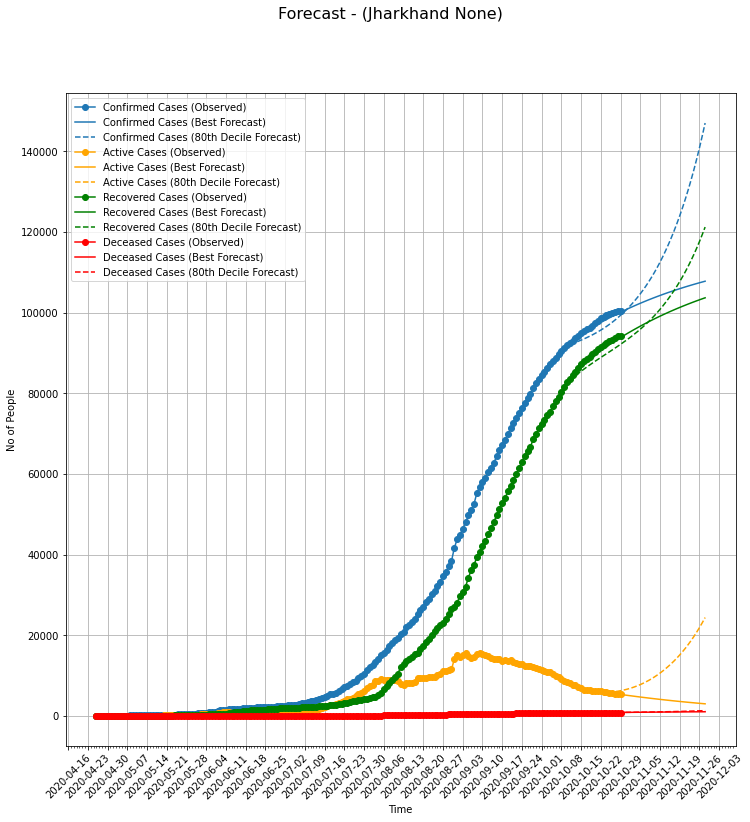

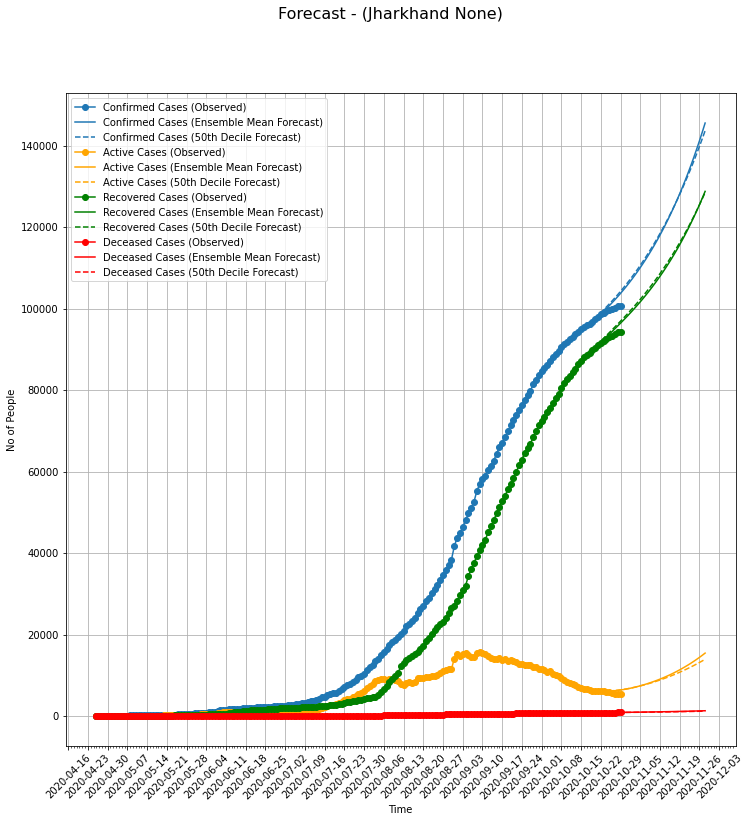

In [22]:
predictions_dict['m2']['plots']['forecast_best_50'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 50], error_bars=False)
predictions_dict['m2']['plots']['forecast_best_80'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 80], error_bars=False)
predictions_dict['m2']['plots']['forecast_ensemble_mean_50'] = plot_forecast(predictions_dict, 
                                                                             (config['fitting']['data']['dataloading_params']['state'], 
                                                                              config['fitting']['data']['dataloading_params']['district']),
                                                                             fits_to_plot=['ensemble_mean', 50], error_bars=False)

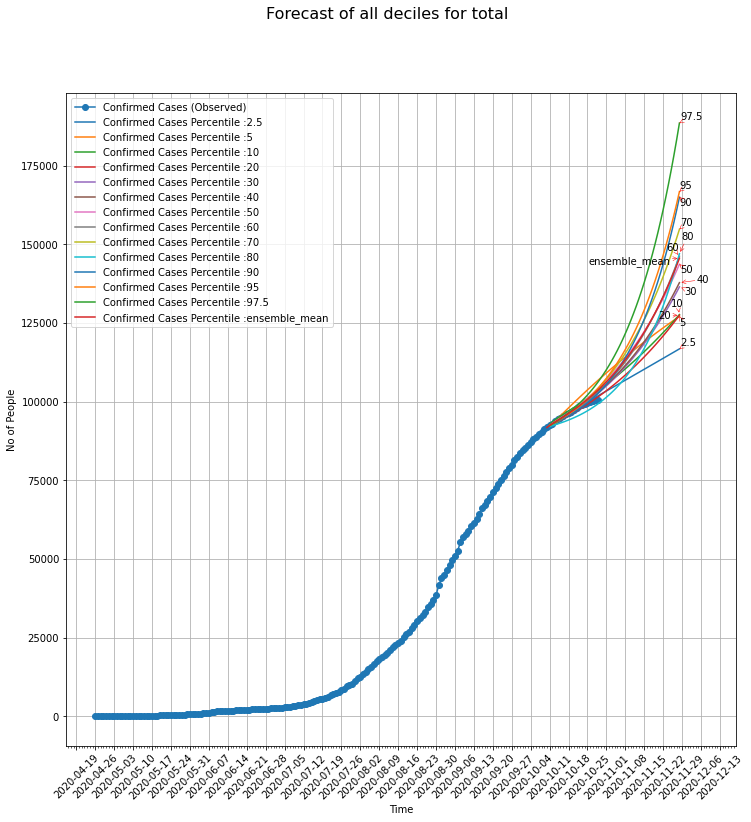

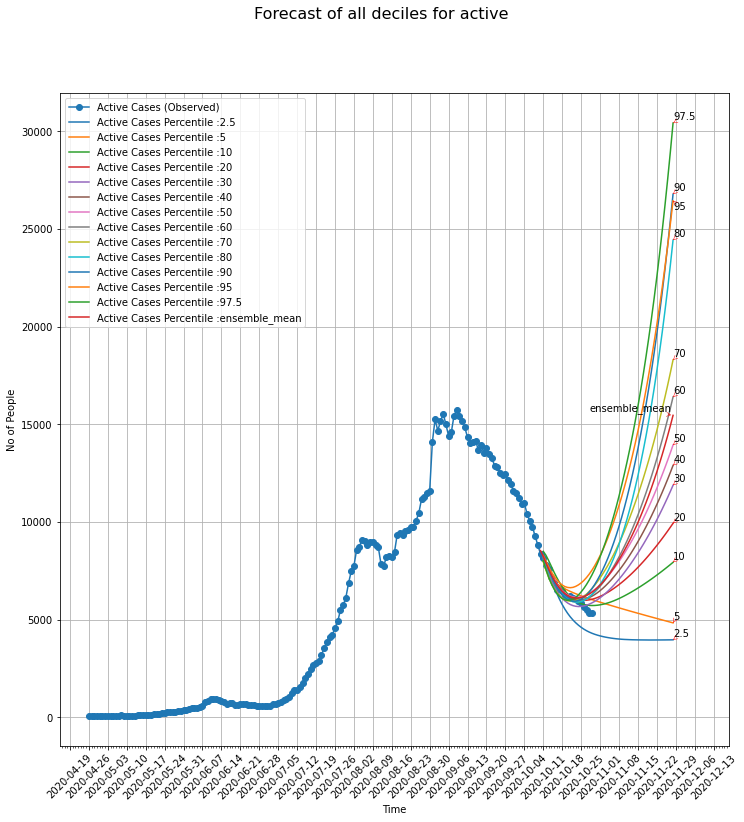

In [23]:
ptiles_plots = plot_ptiles(predictions_dict, which_compartments=config['forecast']['plot_ptiles_for_columns'])
predictions_dict['m2']['plots']['forecasts_ptiles'] = {}
for column in config['forecast']['plot_ptiles_for_columns']:
    predictions_dict['m2']['plots']['forecasts_ptiles'][column.name] = ptiles_plots[column]

## What If Scenarios - R0 Multipliers

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..


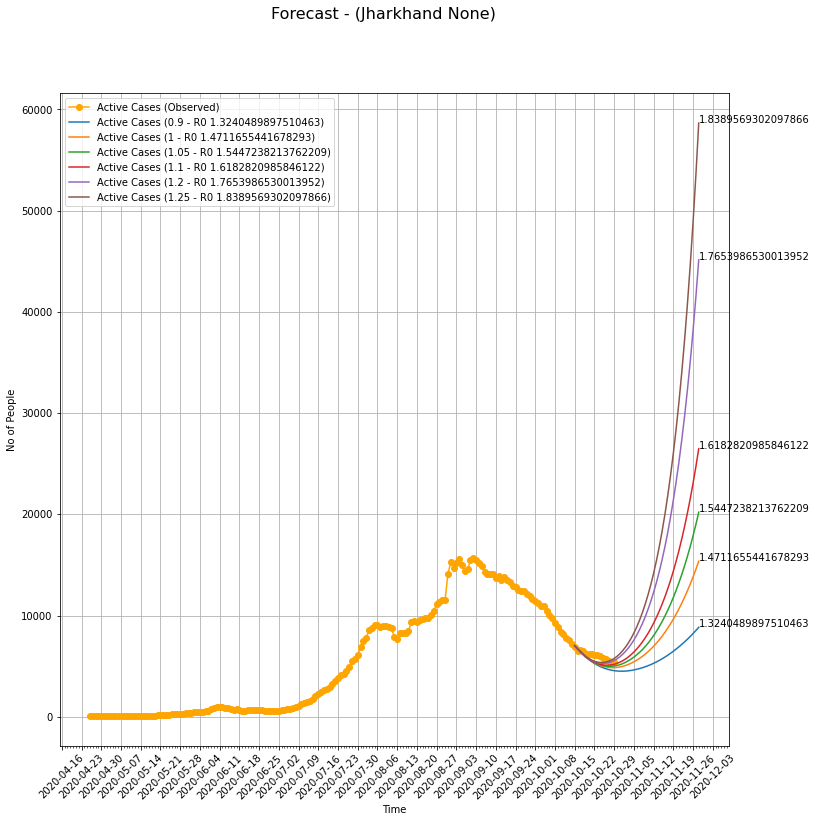

In [24]:
r0_mul_params= predictions_dict['m2']['deciles'][config['what_ifs']['percentile']]['params']
predictions_dict['m2']['r0_mul_dict'] = predict_r0_multipliers(predictions_dict, r0_mul_params, model=config['fitting']['model'],            days=config['forecast']['forecast_days'], multipliers=config['what_ifs']['multipliers'])
predictions_dict['m2']['plots']['r0_mul_dict'] = plot_r0_multipliers(predictions_dict, None, predictions_dict['m2']['r0_mul_dict'], None, config['fitting']['data']['dataloading_params']['state'], config['fitting']['data']['dataloading_params']['district'])

## Create Report

In [25]:
save_dict_and_create_report(predictions_dict, config, ROOT_DIR=output_folder, config_filename=config_filename)

## Create Output

In [26]:
df_output = create_decile_csv_new(predictions_dict)
df_output.to_csv(f'{output_folder}/deciles.csv')

In [27]:
#log_wandb(predictions_dict)

## Create All Trials Output

In [28]:
df_all = create_all_trials_csv(predictions_dict)
df_all.to_csv(f'{output_folder}/all_trials.csv')

## Create R0 Multiplier Output

In [29]:
save_r0_mul(predictions_dict['m2']['r0_mul_dict'], output_folder)

## Create df_district Output

In [30]:
predictions_dict['m1']['df_district'].to_csv(f'{output_folder}/df_district.csv')